In [0]:
!pip install tqdm
!pip install mysql-connector-python

    100% |████████████████████████████████| 8.1MB 3.8MB/s 


In [0]:
import mysql.connector

'''pip install mysql-connector-python'''
conn = mysql.connector.connect(
         user='foouser',
         password='F88Pa%%**',
         host='134.209.144.239',
         database='stocksdb')
print(conn)

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pandas_datareader import data
import os
import datetime as dt
import urllib.request,json

from sklearn import linear_model 


In [0]:
data_source = 'alphavantage' # alphavantage 

if data_source == 'alphavantage':
    
    api_key = 'AGM72XDDHC20U6HE'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)
        
else:
  print("something went wrong")

Data saved to : stock_market_data-AAL.csv


In [0]:
df = df.sort_values('Date')
training_set = df.iloc[:, 1:2].values



print("               -------Tail Data-------         ")
df.tail()

               -------Tail Data-------         


,Date,Low,High,Close,Open
3408,2019-04-12,34.5,35.235,34.69,34.99
3409,2019-04-15,33.68,35.24,33.75,34.65
3410,2019-04-16,33.59,34.09,34.03,33.96
3411,2019-04-17,34.1031,34.72,34.38,34.45
3412,2019-04-18,33.9,34.6199,34.37,34.43


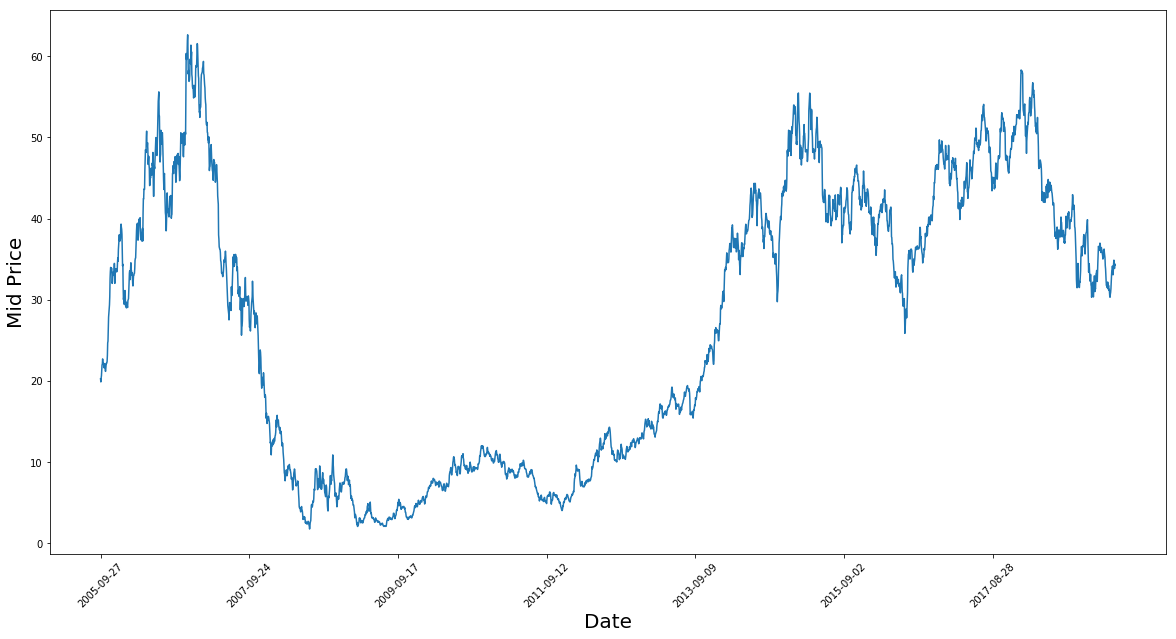

In [0]:
# Visualizing


plt.figure(figsize = (20,10))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=20)
plt.ylabel('Mid Price', fontsize=20)
plt.show()

In [0]:
print("checking if any null values are present\n", df.isna().sum())

checking if any null values are present
 Date                   0
Low                    0
High                   0
Close                  0
Open                   0
Close: 30 Day Mean    29
dtype: int64


In [0]:
# Feature Scaling

from sklearn.preprocessing import MinMaxScaler  

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:


X_train = []    #we start creating data in 60 timesteps and convert it to numpy array
y_train = []
for i in range(60, 2035):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print("Train Data Size: ",[len(X_train)])


Train Data Size:  [1975]


In [0]:
# building LSTM

from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Dense

regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100 , batch_size = 32 )

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1975/1975 [==============================] - 12s 6ms/step - loss: 0.0169
Epoch 2/100
1975/1975 [==============================] - 9s 5ms/step - loss: 0.0032
Epoch 3/100
1975/1975 [==============================] - 9s 5ms/step - loss: 0.0027
Epoch 4/100
1975/1975 [==============================] - 9s 5ms/step - loss: 0.0029
Epoch 5/100
1975/1975 [==============================] - 10s 5ms/step - loss: 0.0025
Epoch 6/100
1975/1975 [==============================] - 9s 5ms/step - loss: 0.0026
Epoch 7/100
1975/1975 [==============================] - 9s 5ms/step - loss: 0.0023
Epoch 8/100
1975/1975 [==============================] - 9s 5ms/step - loss: 0.0023
Epoch 9/100
1975/1975 [==============================] - 9s 5ms/step - loss: 0.0028
Epoch 1

In [0]:
# testing

dataset_test = pd.read_csv('stock_market_data-AAL.csv')
real_stock_price = dataset_test.iloc[:, 2:4].values

In [0]:
dataset_total = pd.concat((df['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 76):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

print("Test Data Size:",[len(X_test)])


Test Data Size: [16]


In [0]:
type(real_stock_price)

numpy.ndarray

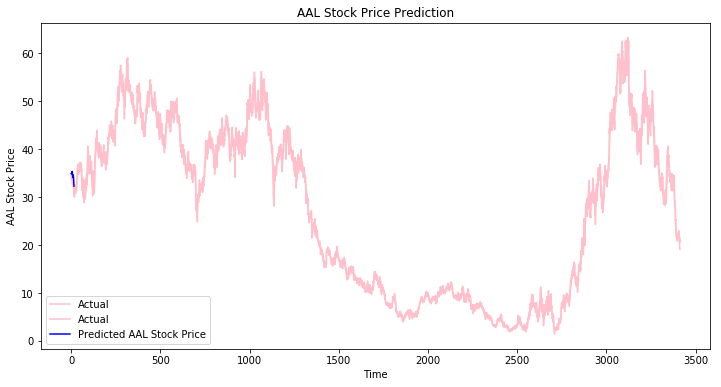

In [0]:

# #Visualizing Prediction
plt.figure(figsize = (12,6))
plt.plot(real_stock_price, color = 'pink', label = 'Actual')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted AAL Stock Price')
plt.title('AAL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAL Stock Price')
plt.legend()
plt.show()



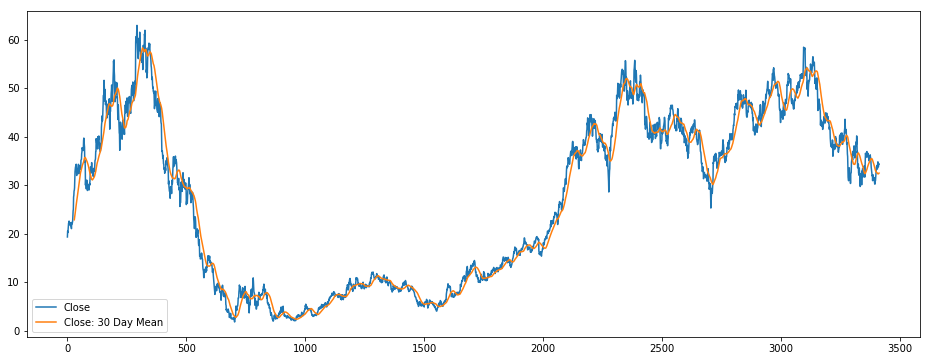

In [0]:
# prediction
df['Close: 30 Day Mean'] = df['Close'].rolling(window=30).mean()  # stock closings
df[['Close','Close: 30 Day Mean']].plot(figsize=(16,6))




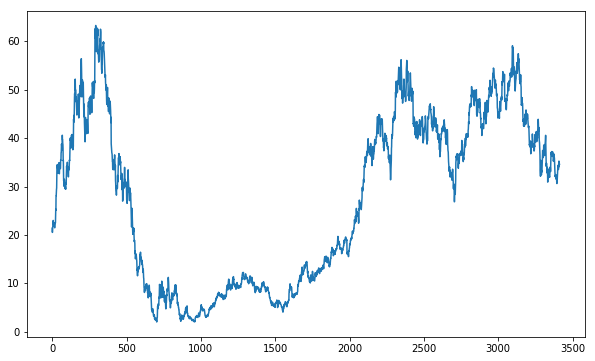

In [0]:

# stocks openning

df['High'].plot(figsize=(10,6))


In [0]:
|# Conclusion :  This grows super-linear with the number of time steps we try to predict.